In [1]:
import os
import random # use to generate the noise(vector) 
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Root directory for dataset
dataroot = "pretty_face"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

#Size of z latent vector (i.e. size of generator input)
nz = 100
# 
# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# # Number of training epochs
# num_epochs = 40
# 
# # Learning rate for optimizers
# lr = 0.0002
# 
# # Beta1 hyperparam for Adam optimizers
# beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

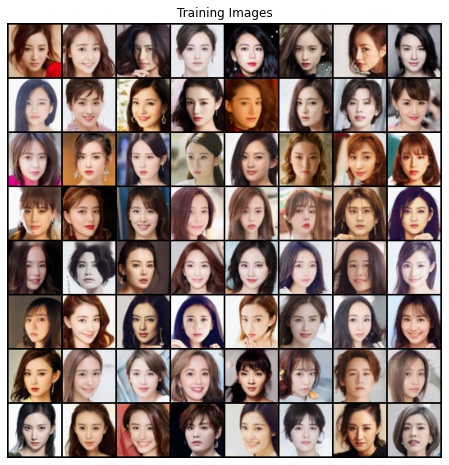

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size), # padding
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
# 加载模型
model=netG
# 加载预训练模型的参数
model.load_state_dict(torch.load("prettyFace_Generater_size64.pth"))

<All keys matched successfully>

In [8]:
torch.manual_seed(0)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
img_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake[:4], nrow=2,padding=2, normalize=True))

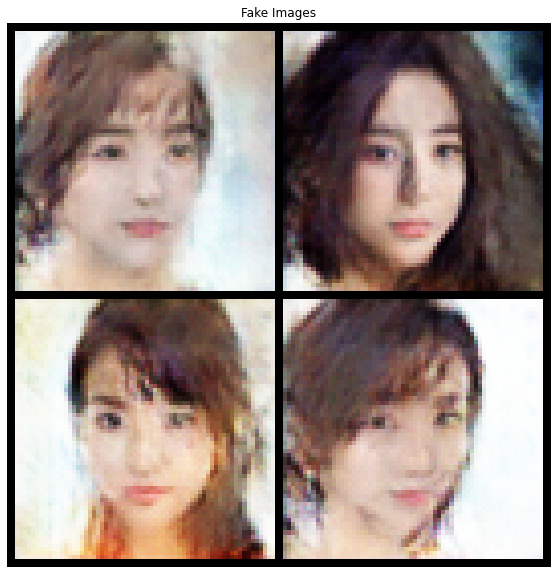

In [9]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

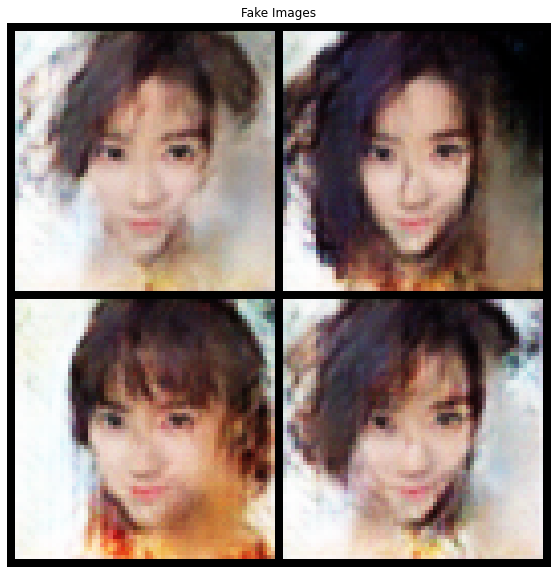

In [10]:
fixed_noise2 = fixed_noise - 1.5

img_list2 = []
with torch.no_grad():
    fake = netG(fixed_noise2).detach().cpu()
    img_list2.append(vutils.make_grid(fake[:4], nrow=2,padding=2, normalize=True))

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list2[-1],(1,2,0)))
plt.show()

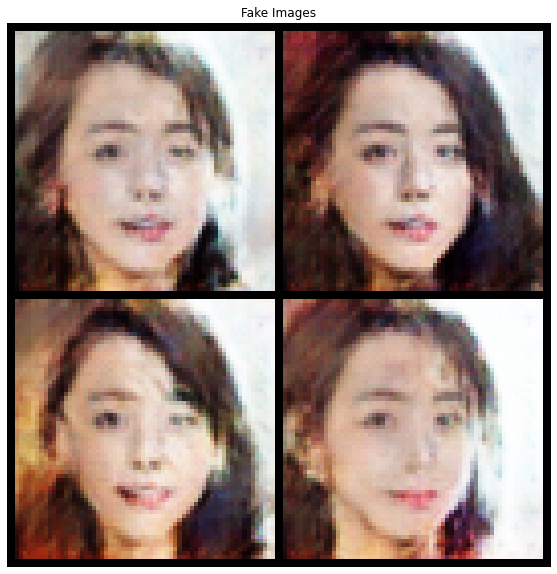

In [11]:
fixed_noise2 = fixed_noise + 1.5

img_list2 = []
with torch.no_grad():
    fake = netG(fixed_noise2).detach().cpu()
    img_list2.append(vutils.make_grid(fake[:4], nrow=2,padding=2, normalize=True))

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list2[-1],(1,2,0)))
plt.show()

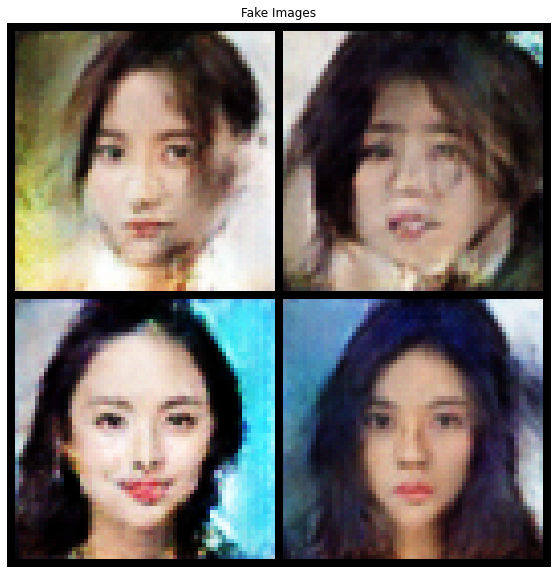

In [12]:
torch.manual_seed(46)
fixed_noise3 = torch.randn(64, nz, 1, 1, device=device)
img_list3 = []
with torch.no_grad():
    fake = netG(fixed_noise3).detach().cpu()
    img_list3.append(vutils.make_grid(fake[:4], nrow=2,padding=2, normalize=True))

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list3[-1],(1,2,0)))
plt.show()

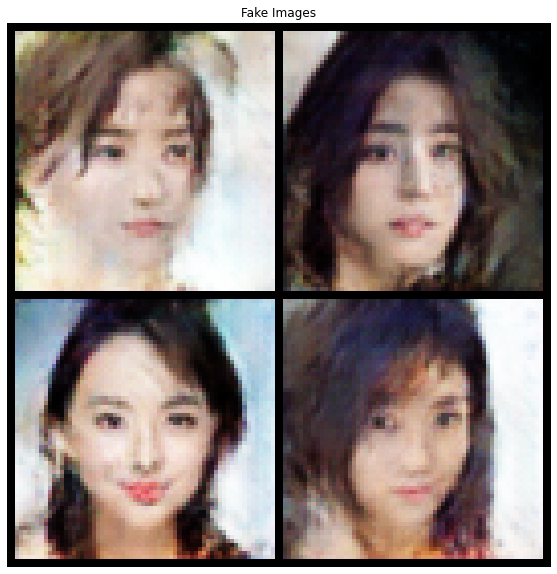

In [13]:
fixed_noise2 = fixed_noise+fixed_noise3

img_list2 = []
with torch.no_grad():
    fake = netG(fixed_noise2).detach().cpu()
    img_list2.append(vutils.make_grid(fake[:4], nrow=2,padding=2, normalize=True))

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list2[-1],(1,2,0)))
plt.show()

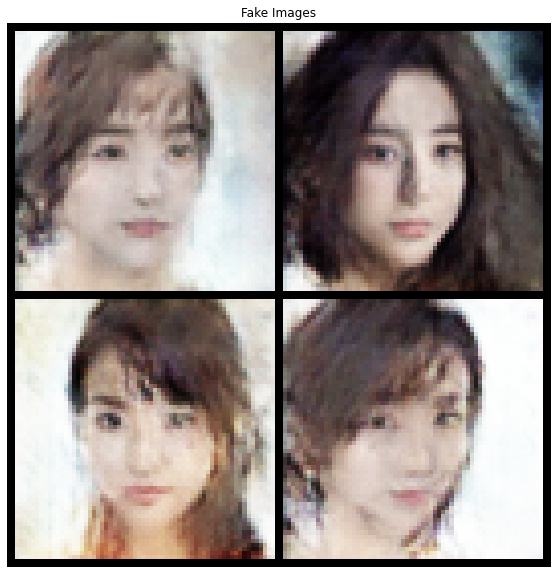

In [14]:
# change the style of the photos
transform = transforms.Compose([transforms.ColorJitter(brightness=(0), 
                                                       contrast=(0), saturation=(0.5), hue=(0, 0))])
new_img = transform(img_list[-1])

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(new_img,(1,2,0)))
plt.show()

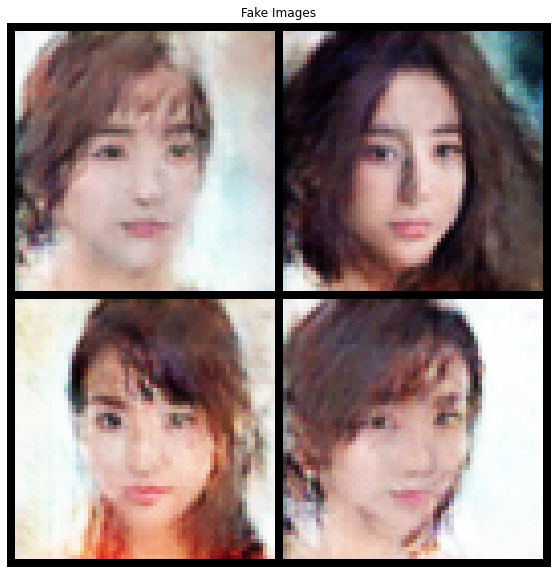

In [15]:
transform = transforms.Compose([transforms.ColorJitter(brightness=(0), 
                                                       contrast=(0), saturation=(0), hue=(-0.05, 0))])
new_img = transform(img_list[-1])

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(new_img,(1,2,0)))
plt.show()

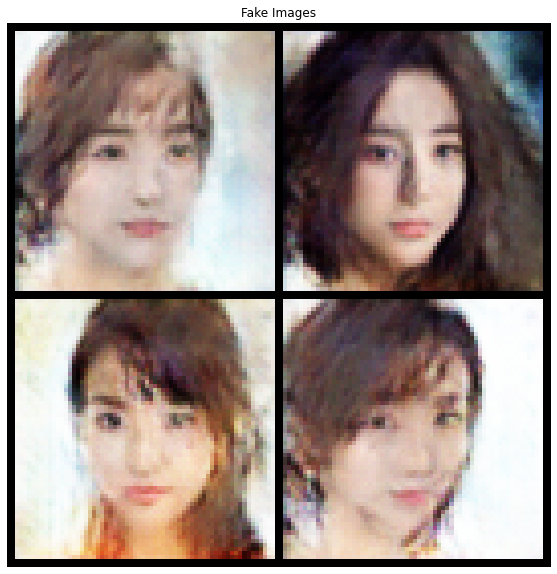

In [16]:
transform = transforms.Compose([transforms.ColorJitter(brightness=(0), 
                                                       contrast=(0), saturation=(0), hue=(0, 0.05))])
new_img = transform(img_list[-1])

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(new_img,(1,2,0)))
plt.show()

In [47]:
# torch.manual_seed(46)
# fixed_noise_temp = torch.randn(64, nz, 1, 1, device=device)

linearly_interpolate_img_list = []
for bais in range(20):
    fixed_noise_temp = fixed_noise -1.5 + bais*3/20
    with torch.no_grad():
        fake = netG(fixed_noise_temp).detach().cpu()
        linearly_interpolate_img_list.append(vutils.make_grid(fake[:4], nrow=2,padding=2, normalize=True))

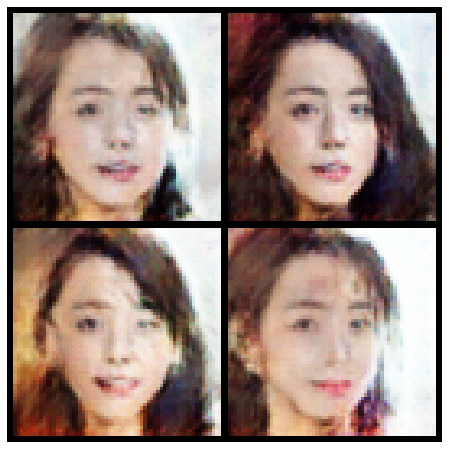

In [50]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in linearly_interpolate_img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [51]:
#help(animation.ArtistAnimation)

In [ ]:
import imageio
def create_gif(image_list, gif_name, duration = 1.0):
    '''
    :param image_list: 这个列表用于存放生成动图的图片
    :param gif_name: 字符串，所生成gif文件名，带.gif后缀
    :param duration: 图像间隔时间
    :return:
    '''
    frames = []
    for image_name in image_list:
        frames.append(imageio.imread(image_name))
    imageio.mimsave(gif_name, frames, 'GIF', duration=duration)
    return

image_list=[]
#这里放上自己所需要合成的图片
for i in range(50):
    path='F:\\jupyter notebook workspace\\photo\\GA_gif\\'+str(i)+'.png'
    image_list.append(path)
gif_name = 'F:\\jupyter notebook workspace\\photo\\GA_gif\\GA.gif'
duration = 0.2
create_gif(image_list, gif_name, duration)